In [1]:
# --- Setup: make local package importable from /src and load core functions ---
# Notebook runs from /notebooks, so we add ../src to sys.path.
# Keep imports minimal here; anything reusable should live in src/picml/.
import sys
from pathlib import Path

# we are in notebooks/, so repo root is one level up
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT / "src"))

from picml.dataio import load_case_C
print("✅ Imported load_case_C")

✅ Imported load_case_C


In [2]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/picml/bin/python
3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]


In [3]:
import tensorflow as tf
print(tf.__version__)


2026-01-09 10:17:43.008614: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 10:17:43.008857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 10:17:43.051651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 10:17:43.992328: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

2.20.0


In [4]:
from picml.utils import fidelity_imag
from picml.theory import filter_by_puc_phase_ring_major

In [5]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow import keras

In [6]:
import numpy as np
import os

# --- Load Case B dataset (measured spectra X and targets y) ---
# X: measured spectra per ring (rows = chains*rings, cols = frequency bins)
# y: onsite loss per ring (same row order as X)

X, y,datay0,datay1 = load_case_C(use_compensated=False)
#y = y.reshape(-1, 1)

print("X:", X.shape)
print("y:", y.shape)

X: (2400, 40)
y: (2400, 2)


In [7]:
#Selecting the data from the available data such that they lie between resonant frequency + epsilon and resonant frequency -epsilon
epsilon = np.array([5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5])/1.
chosen0, chosen1, chosenX = filter_by_puc_phase_ring_major(datay0, datay1, X, np.zeros_like(epsilon), epsilon)
print("shape of chosendatay0:", chosen0.shape)
print("shape of chosendatay1:", chosen1.shape)
print("shape of chosenX:\n", chosenX.shape)

shape of chosendatay0: (1533,)
shape of chosendatay1: (1533,)
shape of chosenX:
 (1533, 40)


In [8]:
choseny = np.stack((chosen0, chosen1), axis=1)
print("choseny shape:", choseny.shape)

choseny shape: (1533, 2)


In [9]:
# --- Train/test split by chain (not by individual rings) ---
X_train, X_test, y_train, y_test = train_test_split(chosenX, choseny, test_size=0.2)

In [10]:
# --- Scale inputs (X,y) 
# IMPORTANT: fit scaler on train only; apply to test with transform().
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

target_scaler = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train0=y_train[:,0].reshape(-1,1)
target_scaler.fit(y_train0)
y_train_scaled0=target_scaler.transform(y_train[:,0].reshape(-1,1))
y_test_scaled0=target_scaler.transform(y_test[:,0].reshape(-1,1))

target_scaler1 = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train1=y_train[:,1].reshape(-1,1)
target_scaler1.fit(y_train1)
y_train_scaled1=target_scaler1.transform(y_train[:,1].reshape(-1,1))
y_test_scaled1=target_scaler1.transform(y_test[:,1].reshape(-1,1))

y_test_scaled = np.hstack([y_test_scaled0, y_test_scaled1])
y_train_scaled = np.hstack([y_train_scaled0, y_train_scaled1])

In [11]:
# --- Stage 1: predict onsite loss from measured spectra ---
# Model 1 learns y from X_train_scaled.
# Keep a short smoke-test first; increase epochs only after plumbing works.

from picml.models import create_model_C_1

model = create_model_C_1(input_shape=X_train_scaled.shape[1:])
model.summary()


2026-01-09 10:17:47.123519: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 600)            │       480,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 400)            │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 754,602 (2.88 MB)

 Trainable params: 754,602 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Stage 1 evaluation ---
# Print a few predictions vs truth to catch obvious failures (constant output, NaNs, etc.).

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=2,          # just a smoke test
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss:", float(loss))

Epoch 1/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9629 - val_loss: 2.2130
Epoch 2/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8510 - val_loss: 1.5487
Test loss: 1.363022804260254


In [13]:
from picml.models import create_model_C_1
from picml.utils import learning_rate_scheduler

# Build + compile
model = create_model_C_1(input_shape=X_train_scaled.shape[1:])
model.compile(optimizer="adam", loss="mse")
lr_scheduler_callback = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

# Train (use raw y)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[lr_scheduler_callback]
)

# Evaluate
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("Test loss:", float(loss))

# Predictions (optional)
y_pred_train = model.predict(X_train_scaled)
y_pred_test  = model.predict(X_test_scaled)

print("y_pred_train:", y_pred_train.shape, "y_train:", y_train.shape)
print("y_pred_test :", y_pred_test.shape,  "y_test :", y_test.shape)

phase_pred_train = target_scaler.inverse_transform(y_pred_train[:, 0].reshape(-1, 1))
loss_pred_train = target_scaler1.inverse_transform(y_pred_train[:, 1].reshape(-1, 1))

phase_pred_test = target_scaler.inverse_transform(y_pred_test[:, 0].reshape(-1, 1))
loss_pred_test = target_scaler1.inverse_transform(y_pred_test[:, 1].reshape(-1, 1))


print("Phase train predictions shape:", phase_pred_train.shape)
print("Loss train predictions shape:", loss_pred_train.shape)
print("y_train shape:", y_train.shape)

print("Phase test predictions shape:", phase_pred_test.shape)
print("Loss test predictions shape:", loss_pred_test.shape)
print("y_test shape:", y_test.shape)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2813 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1932 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1665 - val_loss: 0.1475 - learning_rate: 9.5062e-04
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1520 - val_loss: 0.1336 - learning_rate: 9.2686e-04
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1339 - val_loss: 0.1233 - learning_rate: 9.0369e-04
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1244 - val_loss: 0.1235 - learning_rate: 8.8110e-04
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1181 - val_loss: 0.1123 - learning_rate: 8.5907e-04
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1122 - val_loss: 0.1058 - learning_rate: 8.3759e-04
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1059 - val_loss: 0.1012 - learning_rate: 8.

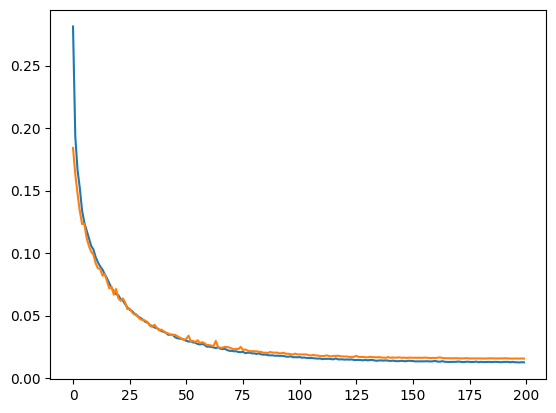

In [14]:
loss_array=np.array(history.history['loss'])
vals_array=np.array(history.history['val_loss'])

plt.plot(loss_array)
plt.plot(vals_array)

In [15]:
# --- Stage 1 diagnostic metric (fidelity/correlation-like) ---
# Uses picml.utils.fidelity_imag; do not redefine it here.
# Watch out: if predictions collapse to constant, variance ~0 and fidelity can be NaN.
phase_train_true = target_scaler.inverse_transform(y_train_scaled[:, 0].reshape(-1, 1))
loss_train_true = target_scaler1.inverse_transform(y_train_scaled[:, 1].reshape(-1, 1))

phase_test_true = target_scaler.inverse_transform(y_test_scaled[:, 0].reshape(-1, 1))
loss_test_true = target_scaler1.inverse_transform(y_test_scaled[:, 1].reshape(-1, 1))

# Fidelity calculation should only use corresponding values
F_real_train = fidelity_imag(phase_pred_train, phase_train_true)
F_real = fidelity_imag(phase_pred_test, phase_test_true)

F_imag_train = fidelity_imag(loss_pred_train, loss_train_true)
F_imag = fidelity_imag(loss_pred_test, loss_test_true)

print("Train Phase Fidelity:", F_real_train)
print("Test Frequencies Fidelity:", F_real)
print("Train Loss Fidelity:", F_imag_train)
print("Test Loss Fidelity:", F_imag)


Train Phase Fidelity: 0.978485310638958
Test Frequencies Fidelity: 0.9600375728789352
Train Loss Fidelity: 0.943883920900088
Test Loss Fidelity: 0.9038080350067073


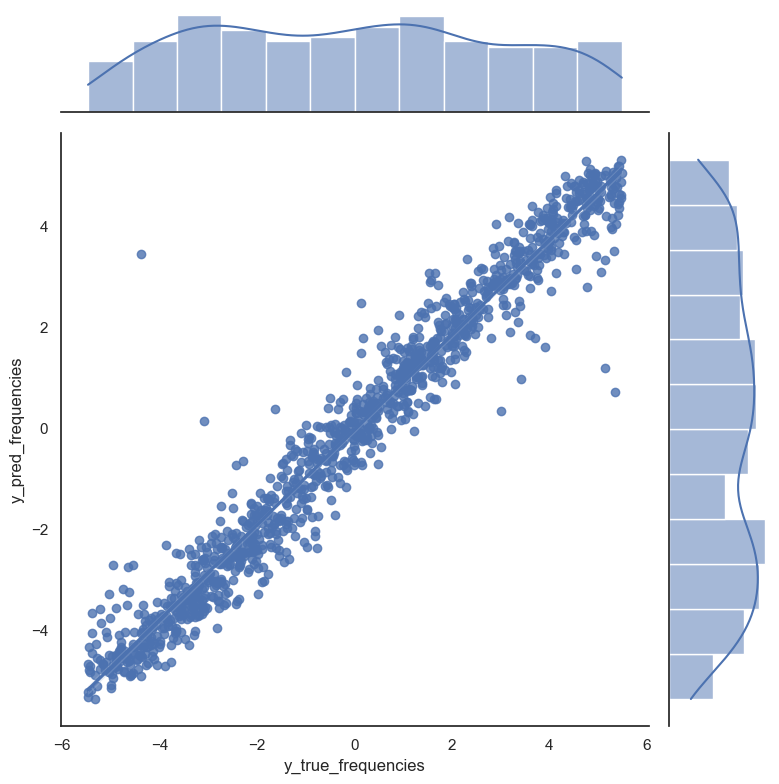

In [16]:
# plot predicted vs true Hamiltonian parameters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train_scaled and y_pred_train are already defined
y_true_frequencies =   phase_train_true# True phase values
y_pred_frequencies = phase_pred_train  # Predicted phase values

# Convert predictions to pandas dataframe
df_pred_train = pd.DataFrame({
    'y_true_frequencies': y_true_frequencies.ravel(),
    'y_pred_frequencies': y_pred_frequencies.ravel()
})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)

# Jointplot for scatter and regression line with histograms
g = sns.jointplot(
    x='y_true_frequencies',
    y='y_pred_frequencies',
    data=df_pred_train,
    kind="reg",  # Use regression plot type to show the line of best fit
    height=8,    # Adjust the size of the plot (optional)
    ratio=5      # Adjust ratio of scatter plot vs marginal histograms (optional)
)

# Show the plot
plt.show()


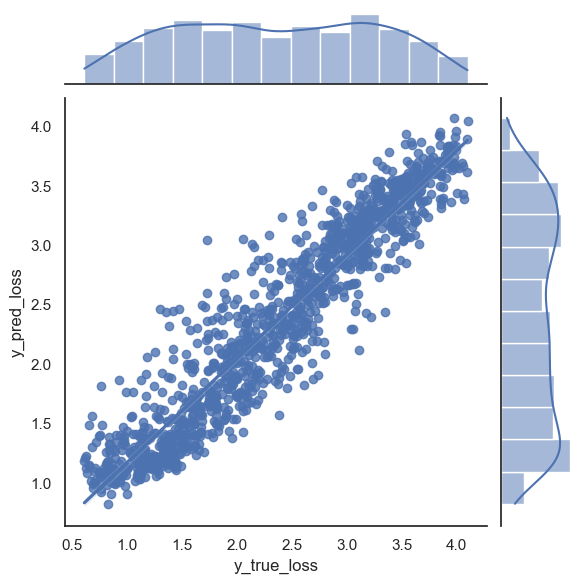

In [17]:
import pandas as pd
import seaborn as sns
y_true_loss = loss_train_true#y_train_scaled[:,1]
y_pred_loss = loss_pred_train#y_pred_train[:,1]

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true_loss':y_true_loss.ravel(), 'y_pred_loss': y_pred_loss.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_loss', y='y_pred_loss', data=df_pred_train, kind="reg")

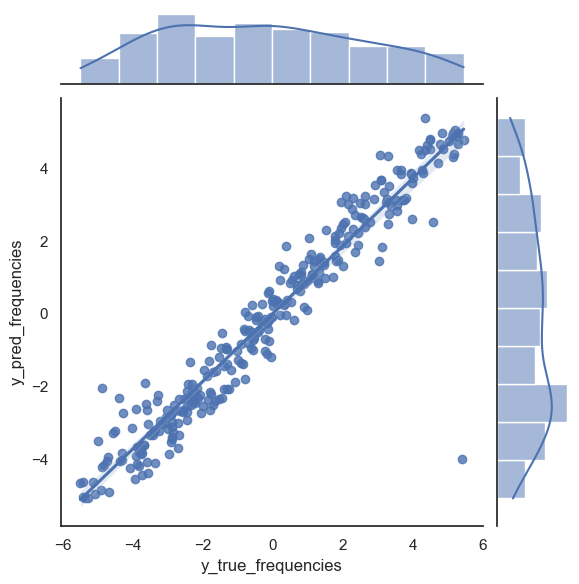

In [18]:
import pandas as pd
import seaborn as sns
y_true_frequencies = phase_test_true#y_test_scaled[:,0]
y_pred_frequencies = phase_pred_test #y_pred_test[:,0]

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true_frequencies':y_true_frequencies.ravel(), 'y_pred_frequencies': y_pred_frequencies.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_frequencies', y='y_pred_frequencies', data=df_pred_test, kind="reg")

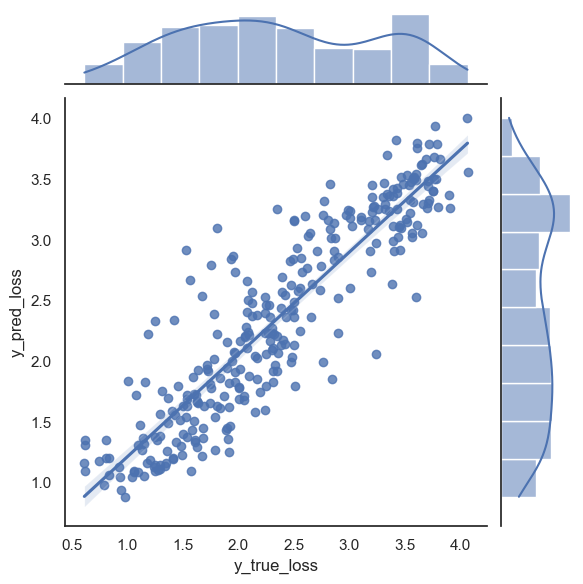

In [19]:
import pandas as pd
import seaborn as sns
y_true_loss = loss_test_true #y_test_scaled[:,1]
y_pred_loss = loss_pred_test#y_pred_test[:,1]

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true_loss':y_true_loss.ravel(), 'y_pred_loss': y_pred_loss.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_loss', y='y_pred_loss', data=df_pred_test, kind="reg")

In [20]:
from pathlib import Path
import numpy as np

from picml.theory import load_frequencies, generate_case_C_model2_spectra
# (or from picml.theory import ... if you renamed)

DATA_DIR = Path.cwd().parent / "data"/"case_C"
freqs = load_frequencies(DATA_DIR / "frequencies.txt", scale_2pi=True)

frequencies_num = list(enumerate(freqs))
print("length of frequencies :", len(freqs))


length of frequencies : 40


In [21]:
y_true_l1 = np.concatenate([ loss_train_true,  loss_test_true], axis=0)[:1528].reshape(-1, 8)
y_pred_l1 = np.concatenate([ loss_pred_train,  loss_pred_test], axis=0)[:1528].reshape(-1, 8)
print("y_true_l1 shape :", y_true_l1.shape)  
print("y_pred_l1 shape :", y_pred_l1.shape)

y_true_f1 = np.concatenate([ phase_train_true,  phase_test_true], axis=0)[:1528].reshape(-1, 8)
y_pred_f1 = np.concatenate([ phase_pred_train,  phase_pred_test], axis=0)[:1528].reshape(-1, 8)
print("y_true_f1 shape :", y_true_f1.shape)  
print("y_pred_f1 shape :", y_pred_f1.shape)

new_chosenX_combined = np.concatenate([X_train/(2. *loss_train_true.flatten()[:, np.newaxis] * 2 * np.pi), X_test/(2. *loss_test_true.flatten()[:, np.newaxis] * 2 * np.pi)], axis=0)[:1624]
print("new_chosenX_combined shape :", new_chosenX_combined.shape)


y_true_l1 shape : (191, 8)
y_pred_l1 shape : (191, 8)
y_true_f1 shape : (191, 8)
y_pred_f1 shape : (191, 8)
new_chosenX_combined shape : (1533, 40)


In [22]:
X_true, X_predicted = (
    generate_case_C_model2_spectra(
        y_true_l1,
        y_pred_l1,
        y_true_f1,
        y_pred_f1,
        frequencies=freqs,
        gamma=0.1,
        coupling=0.82,
    )
)
print("X_true shape :", X_true.shape)  
print("X_predicted shape :", X_predicted.shape) 

X_true shape : (1528, 40)
X_predicted shape : (1528, 40)


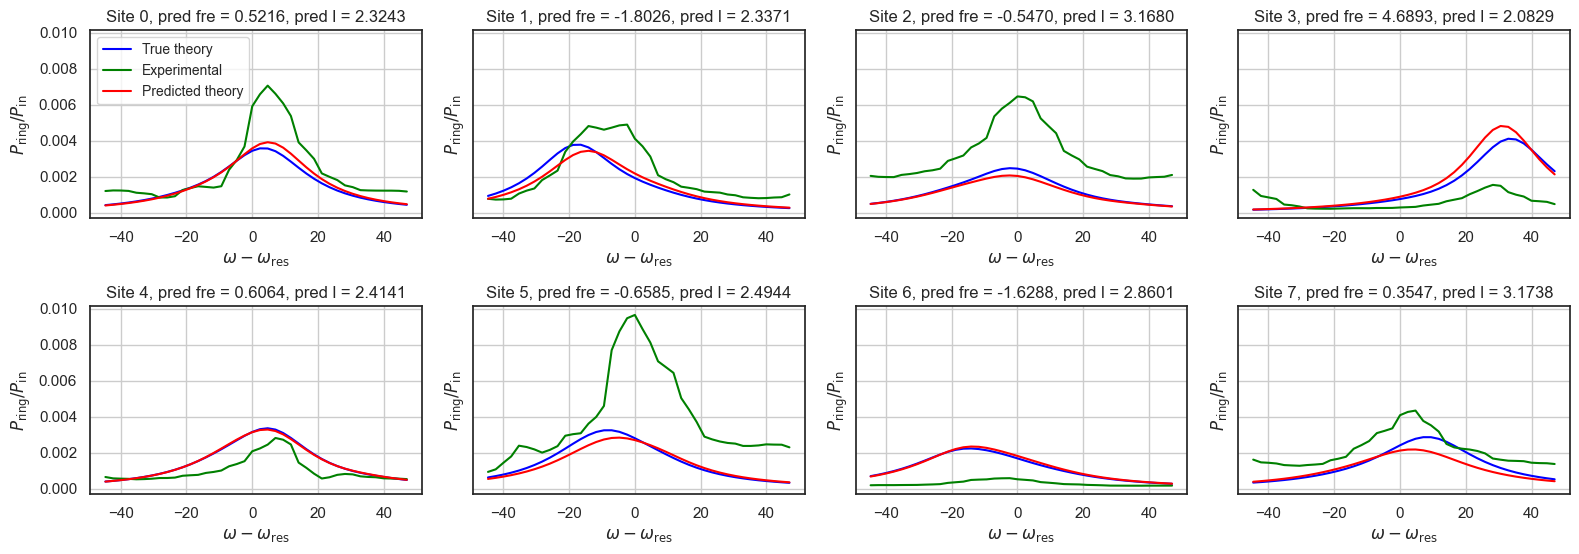

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 15 #0 to 39
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, X_true[i+(8*k), :], label='True theory', color='blue')
    ax.plot(freqs, new_chosenX_combined[i+(8*k), :], label='Experimental', color='green')
    ax.plot(freqs, X_predicted[i+(8*k), :], label='Predicted theory', color='red')

    ax.set_title(f"Site {i}, pred fre = {y_pred_f1[k,i]:.4f}, pred l = {y_pred_l1[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
new_X = X_predicted
new_Y = new_chosenX_combined[:1528]
print(new_X.shape,new_Y.shape)
new_X_train, new_X_test, new_y_train, new_y_test, y_f1_train, y_f1_test,y_l1_train, y_l1_test= train_test_split(new_X, new_Y,y_pred_f1.flatten(),y_pred_l1.flatten(), test_size=0.2)
print(new_X_train.shape)
print(new_X_test.shape)

(1528, 40) (1528, 40)
(1222, 40)
(306, 40)


In [25]:
# --- scale Stage 2 inputs (new_X, new_y) ---

scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)


scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)


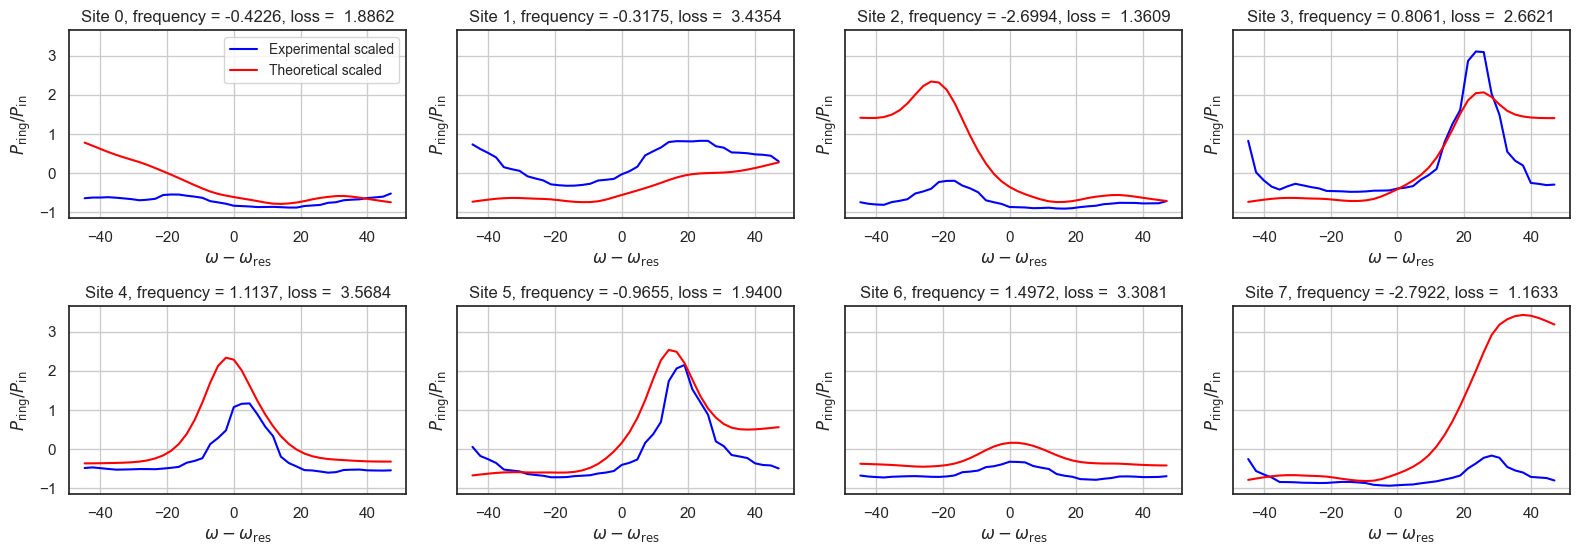

In [26]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 7
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(freqs, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_f1_train[k+i]:.4f}, loss =  {y_l1_train[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [27]:
# --- Stage 2: learn mapping from theory spectra -> corrected/normalized experimental spectra ---
# Model lives in picml.models (keep architecture out of notebook).
# Add channel dim for Conv1D: (n_samples, n_freqs, 1).

import numpy as np
from picml.models import create_model_C_2

# add channel dim for CNN
new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn  = new_X_test_scaled[..., np.newaxis]

model_sc = create_model_C_2(input_shape=new_X_train_scaled_cnn.shape[1:])
model_sc.compile(optimizer="adam", loss="mse")

history_sc = model_sc.fit(
    new_X_train_scaled_cnn,
    new_y_train_scaled,          
    epochs=150,
    batch_size=25,
    validation_split=0.2,
    verbose=1
)



Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6208 - val_loss: 1.3745
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1562 - val_loss: 1.3706
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9316 - val_loss: 1.3782
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7967 - val_loss: 1.3901
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6941 - val_loss: 1.3827
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5967 - val_loss: 1.3871
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5327 - val_loss: 1.3566
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4518 - val_loss: 1.3361
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4017 - val_loss: 1.2988
Epoch 10/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3317 - val_loss: 1.2732
Epoch 11/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2849 - val_loss: 1.1923
Epoch 12/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.

In [28]:

# Evaluate
loss1 = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled)
print(f"Test Loss: {loss1:.6f}")

#loss1 = model1.evaluate(new_X_test_scaled, new_y_test_scaled)
#print(f"Test Loss (noise_std={noise_std}):", loss)

# Predictions
new_y_pred_test = model_sc.predict(new_X_test_scaled)
new_y_pred_train = model_sc.predict(new_X_train_scaled)

print(new_y_pred_train.shape)
print(new_y_train.shape)
print(new_y_pred_test.shape)
print(new_y_test.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8652 
Test Loss: 0.865220
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1222, 40)
(1222, 40)
(306, 40)
(306, 40)


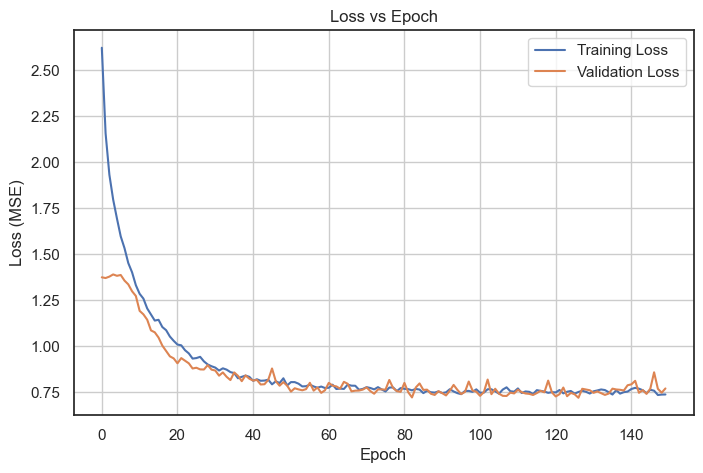

In [29]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc.history['loss']
val_loss = history_sc.history['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)

true_y_train = new_y_train
true_y_test = new_y_test

In [31]:
import numpy as np
from picml.utils import distance_label

x = y_l1_test
y = y_f1_test
c = distance_label(x, y)

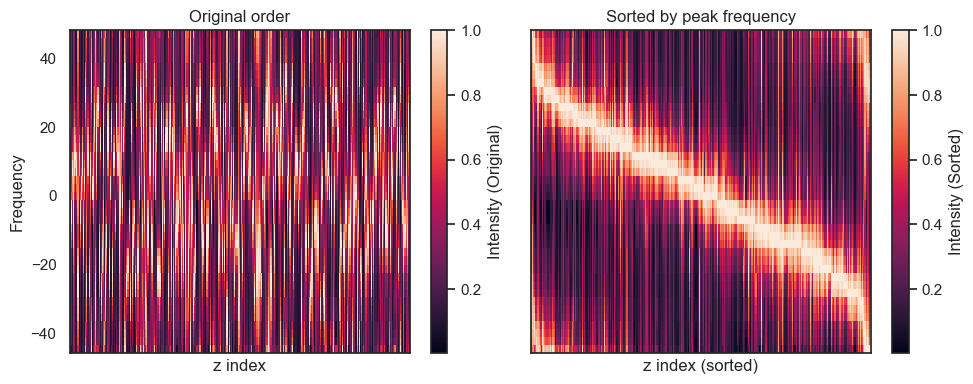

In [32]:
# --- Stage 2 evaluation and qualitative check --- for true power spectra
# Plot a few spectra overlays to see whether model 2 corrects systematic mismatch.
# Use shared color limits when comparing heatmaps across panels.

import numpy as np
import matplotlib.pyplot as plt
from picml.utils import sort_by_peak_frequency

# --- Example data ---
z = np.array(c)
frequencies1 = np.array(freqs)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)


# --- Sorting by where each row peaks ---
z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [33]:
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)

Sk_new = Sk[order, :]

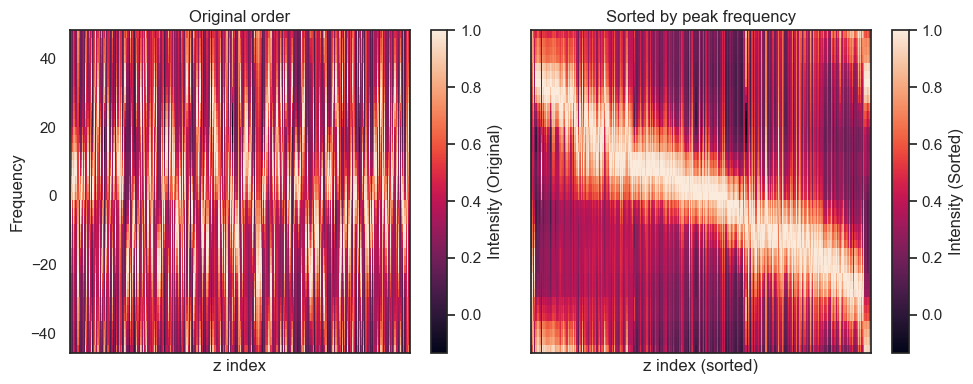

In [34]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [48]:
#Save final output file

import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "predicted_result/spectra_sorted_case_C.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted_case_C.dat with shape", data.shape)

✅ Saved spectra_sorted.dat with shape (12240, 5)


"The End"